<a href="https://colab.research.google.com/github/filmateus/data_science_financas/blob/main/strocks_market_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnicas de previsão temporal de uma ação.

In [4]:
# Data Handling and Analysis
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy import stats
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Time Series Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Plotting and Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Configurations
import warnings
warnings.filterwarnings("ignore")

# Configuração dos gráficos
from matplotlib import rc

# Estilo dos gráficos
# Referência: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # Formato das imagens

# Configurações de fontes
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":9})
rc('mathtext', **{"default":"regular"})

%matplotlib inline

In [5]:
# Define the date range
start_date = date.today() - timedelta(days=1825)
end_date = date.today()

stock_data = yf.download('PETR4.SA', start=start_date, end=end_date).reset_index()

[*********************100%***********************]  1 of 1 completed


In [6]:
 stock_data.columns = stock_data.columns.get_level_values(0)
 stock_data = stock_data.set_index('Date')
 stock_data.describe().round(3)

Price,Adj Close,Close,High,Low,Open,Volume
count,1242.000,1242.000,1242.000,1242.000,1242.000,1.242000e+03
mean,18.224,29.409,29.832,28.978,29.406,6.637778e+07
std,10.501,6.139,6.124,6.137,6.120,3.790352e+07
min,3.898,11.290,12.180,10.850,11.070,1.282670e+07
25%,9.734,25.302,25.855,24.775,25.317,4.062560e+07
50%,14.857,29.145,29.505,28.730,29.085,5.796445e+07
75%,27.319,34.128,34.592,33.630,34.095,8.137492e+07
max,39.600,42.900,42.940,42.560,42.770,4.902304e+08


## Simulações de Monte Carlo

- Técnica matemática usada para estimar os possíveis resultados de um evento incerto.
- Avaliar o impacto do risco em muitos cenários da vida real, como em inteligência artificial, preços de ações, previsão de vendas, gerenciamento de projetos e preços.
- Como Funciona
    - Cria um modelo de resultados possíveis aproveitando uma distribuição de probabilidade, como uma distribuição uniforme ou normal, para qualquer variável que tenha incerteza inerente.
    -  P´roximo passo consisde recalcular os resultados repetidamente, cada vez usando um conjunto diferente de números aleatórios entre os valores mínimo e máximo.


- Drift: direção que as taxas de retrono tiveram no passado

- Volatividade: V.A.

$$Drift = \mu - \frac{1}{2} \sigma^{2}$$

$$Volatilidade = \sigma Z{Rand(0;1)}$$

- Retorno diários

$$r = (\mu - \frac{1}{2} \sigma{^2})  + \sigma Z [Rand(0;1)$$

- Preço de hoje:

$$S_{t} = S_{t-1} e^{r}$$

<Figure size 1000x500 with 0 Axes>

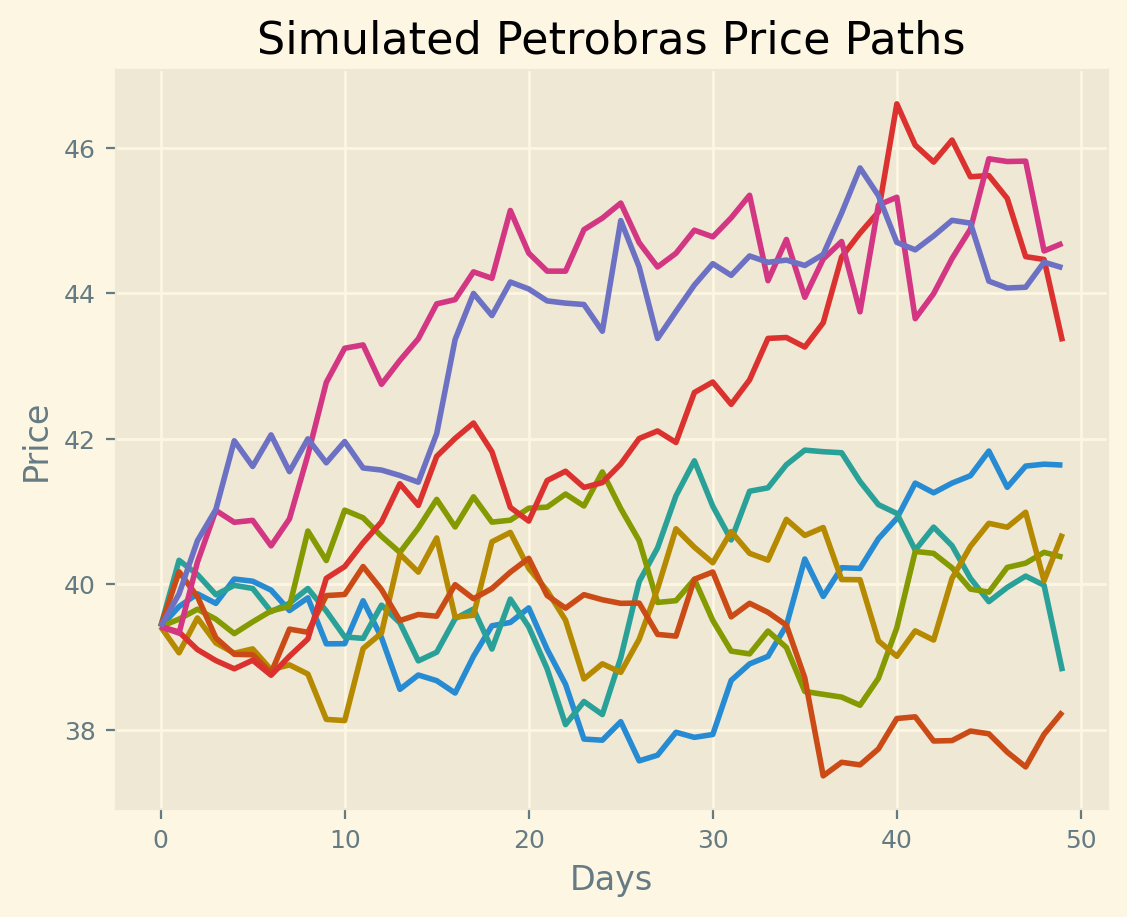

In [7]:
# Set the random seed for reproducibility
np.random.seed(1612)

# Parameters
days = 50  # Number of days to simulate
simulations = 8  # Number of simulation paths

# Normalize the dataset to start at 1
dataset = stock_data[['Close']][-days:]
dataset_normalizado = dataset.copy()
for column in dataset.columns:
    dataset_normalizado[column] = dataset[column] / dataset[column].iloc[0]

# Calculate daily log returns
dataset_taxa_retorno = np.log(dataset_normalizado / dataset_normalizado.shift(1))
dataset_taxa_retorno.fillna(0, inplace=True)

# Calculate mean, variance, and standard deviation of returns
mean_return = dataset_taxa_retorno.mean().values[0]  # Mean log return
variance_return = dataset_taxa_retorno.var().values[0]  # Variance of log return
sd_return = np.sqrt(variance_return)  # Standard deviation

# Generate random samples from the standard normal distribution
Z = stats.norm.ppf(np.random.rand(days, simulations))

# Drift term (expected return adjusted for variance)
drift = mean_return - (0.5 * variance_return)

# Simulated daily returns (Geometric Brownian Motion)
retorno_diarios = np.exp(drift + sd_return * Z)

# Initialize the forecast array
previsoes = np.zeros_like(retorno_diarios)

# Set initial price to the last known price of Petrobras
previsoes[0] = dataset.iloc[-1].values[0]

# Simulate prices for each day and path
for dia in range(1, days):
    previsoes[dia] = previsoes[dia - 1] * retorno_diarios[dia]

# Convert forecasts to a DataFrame for analysis
previsoes_df = pd.DataFrame(previsoes, columns=[f"Simulation_{i+1}" for i in range(simulations)])

plt.figure(figsize=(10,5))
previsoes_df.plot(legend=False, title="Simulated Petrobras Price Paths")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

In [ ]:
# Compute MAPE for each simulation
erros = []
for simulation in previsoes_df.columns:
    mape = mean_absolute_percentage_error(dataset.values.flatten(), previsoes_df[simulation].values)
    erros.append(mape * 100)  # Convert to percentage
    print(f'{simulation}, MAPE: {round(mape*100,2)}')

Simulation_1, MAPE: 3.03
Simulation_2, MAPE: 3.72
Simulation_3, MAPE: 2.5
Simulation_4, MAPE: 2.39
Simulation_5, MAPE: 2.38
Simulation_6, MAPE: 7.07
Simulation_7, MAPE: 10.53
Simulation_8, MAPE: 9.73


## Forecasting Tradicional

Séries temporais são sequências de dados coletados ou registrados em intervalos de tempo específicos e ordenados cronologicamente. Elas são amplamente utilizadas em diversas áreas, como economia, finanças, meteorologia, ciências sociais, entre outras, para analisar padrões, prever tendências futuras e entender a dinâmica temporal dos dados.

In [8]:
adftest = adfuller(stock_data['Close'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.00418754527116
P-Value: 0.008673960800395314
Number of lags: 7
Number of observations: 1234
Critical Values: {'1%': -3.966125125913514, '5%': -3.414053818740398, '10%': -3.1291478893113163}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [9]:
decomposicao = seasonal_decompose(stock_data['Close'], period=len(stock_data['Close']) // 2)
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
aleatorio = decomposicao.resid

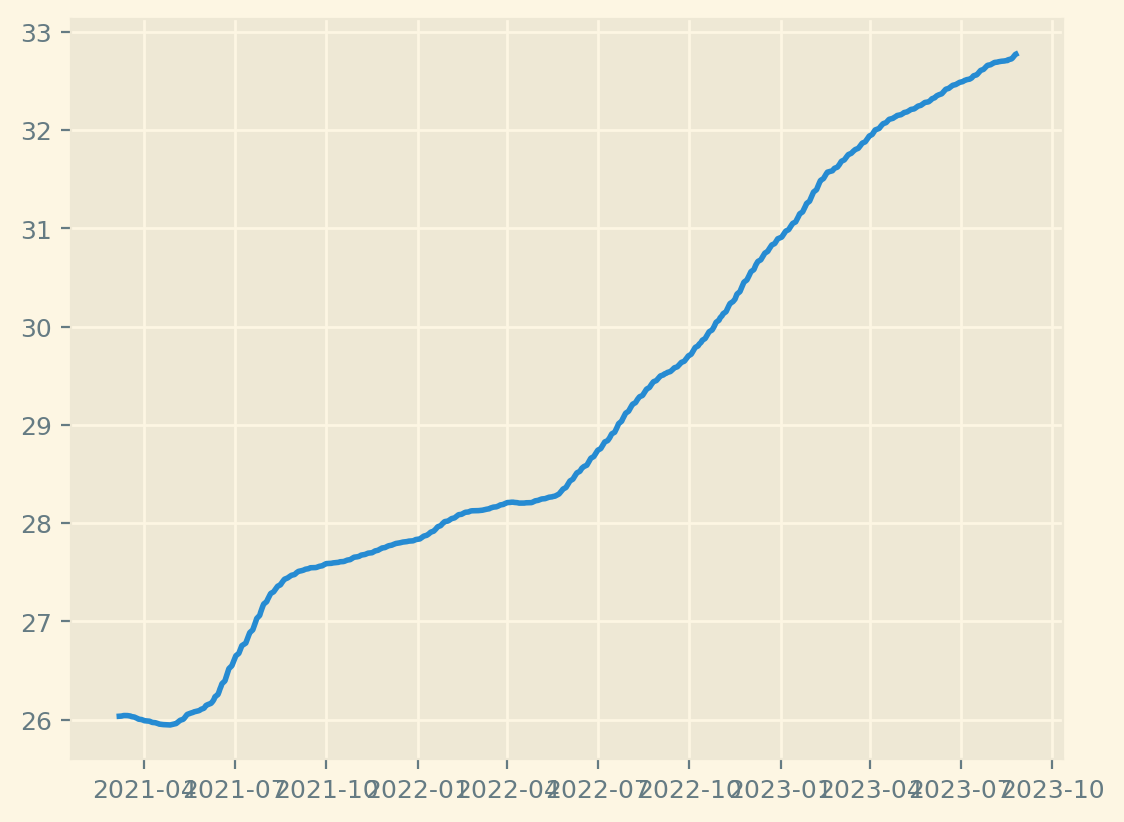

In [10]:
plt.plot(tendencia)

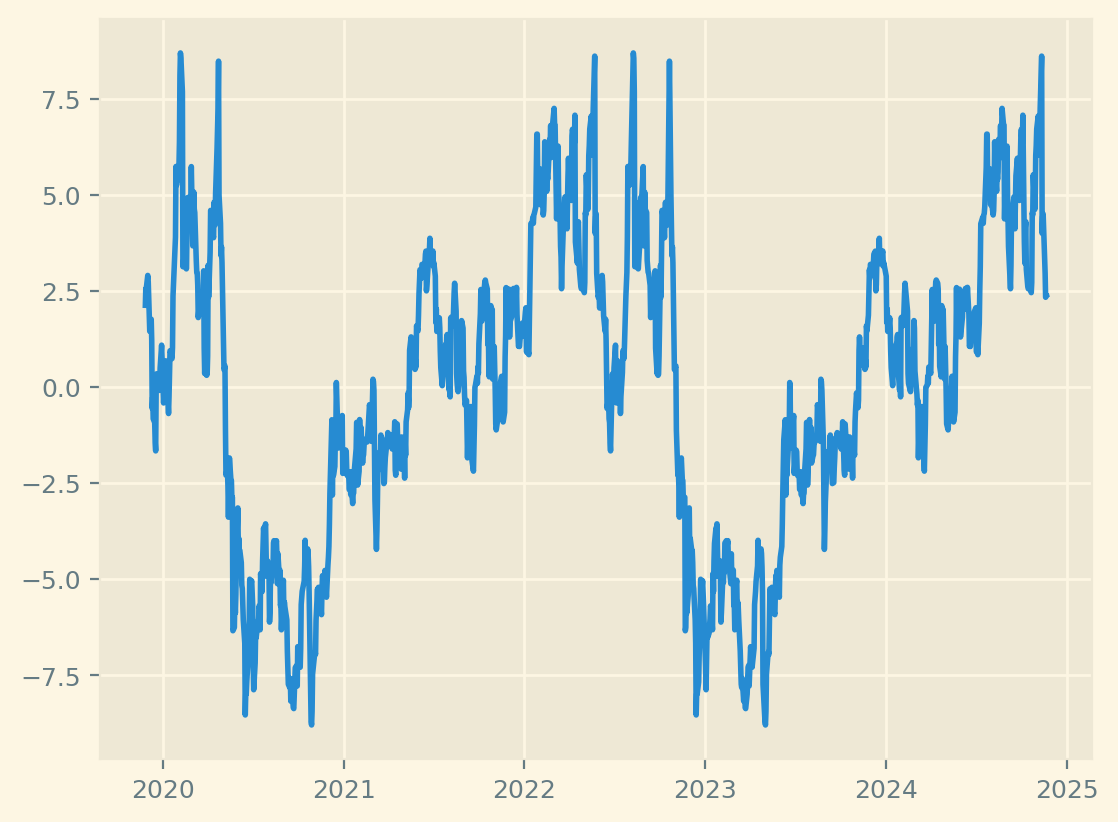

In [11]:
plt.plot(sazonal);

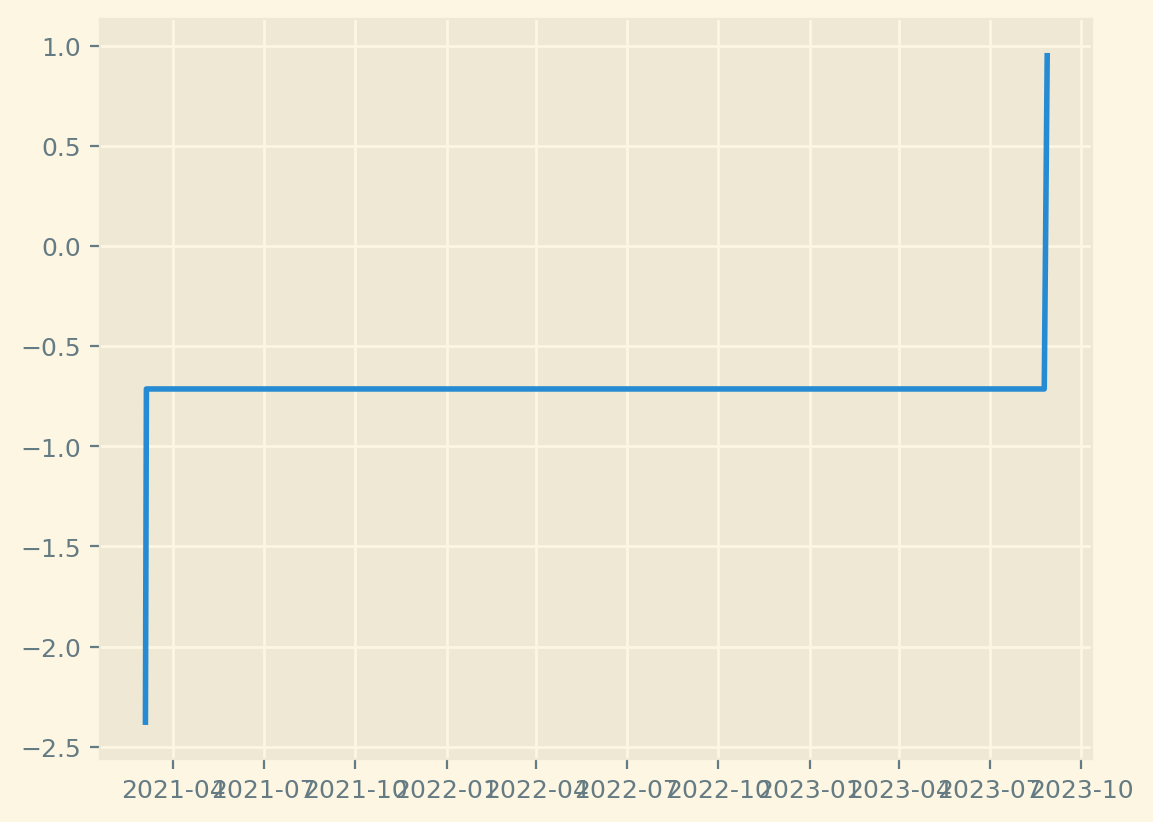

In [12]:
plt.plot(aleatorio);

In [13]:
data = stock_data['Close']
test_size = int(0.10 * len(data))
Y_train, y_test = data[:-test_size], data[-test_size:]
X_train, x_test = np.arange(Y_train.shape[0]), np.arange(Y_train.shape[0], data.shape[0])
X_train.shape, Y_train.shape, y_test.shape, x_test.shape

((1118,), (1118,), (124,), (124,))

In [14]:
model_auto = auto_arima(Y_train, start_p=1, start_q=1,
                    #   exogenous=df[['seasonal_index']],
                      test='adf',
                      max_p=7, max_q=7,
                      m=7,
                      d=1,
                      seasonal=True,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
model_auto.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2611.589, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2617.985, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2610.630, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2610.364, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2616.090, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2619.985, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=2612.273, Time=1.13 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=2612.294, Time=0.74 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=2610.629, Time=0.32 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=6.92 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2608.365, Time=1.31 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2610.274, Time=0.87 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=2610.295, Time=0.57 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2608.633, Time=0.26 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1118
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 7)   Log Likelihood               -1301.229
Date:                             Mon, 25 Nov 2024   AIC                           2606.458
Time:                                     17:36:08   BIC                           2616.494
Sample:                                          0   HQIC                          2610.252
                                            - 1118                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7        0.1030      0.028      3.665      0.000       0.048       0.158
sigma2         0.6016      0.010     57.686      0.000       0.581       0.622
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6143.87
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
n_periods = 30
forecast, conf_int = model_auto.predict(n_periods=n_periods, return_conf_int=True)

forecast_index = pd.date_range(stock_data.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')
forecast_df = pd.DataFrame({'Forecast': forecast, 'Lower CI': conf_int[:, 0], 'Upper CI': conf_int[:, 1]}, index=forecast_index)

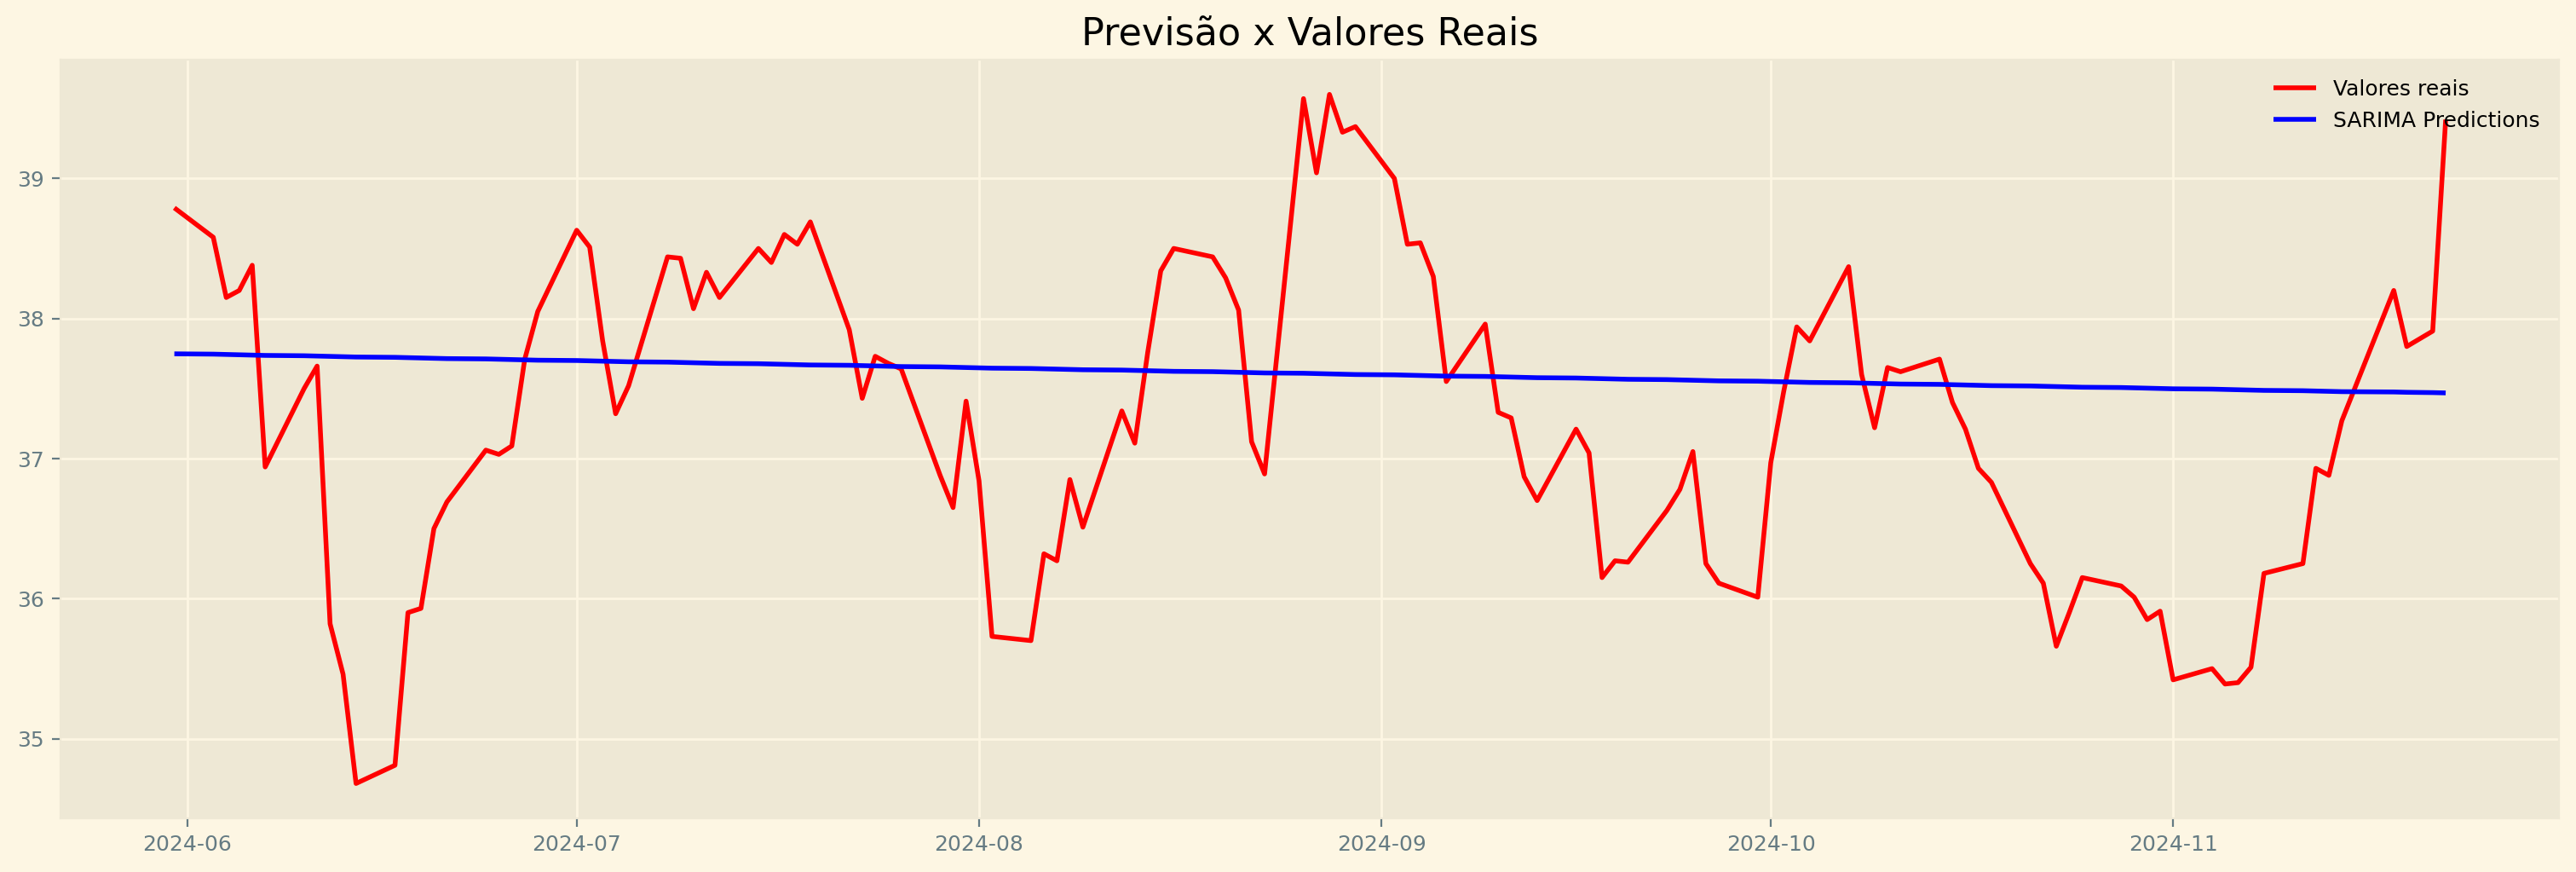

RMSE: 1.12


In [17]:
model_sarima = SARIMAX(Y_train, model =  model_auto.order)
model_sarima = model_sarima.fit()

def pred_sarima():
    y_pred = model_sarima.get_forecast(len(y_test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df['Predictions'] = model_sarima.predict(start = y_pred_df.index[0],
                                                    end = y_pred_df.index[-1])
    y_pred_df.index = y_test.index
    y_pred_out = y_pred_df["Predictions"]
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_size_inches(15, 5)
    plt.plot(y_test, color = "red", label = 'Valores reais')
    plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
    plt.legend(loc='upper right', frameon=False)
    plt.title('Previsão x Valores Reais')
    plt.show()
    testScore1 = root_mean_squared_error(y_test, y_pred_out)
    print('RMSE: %.2f' % (testScore1))

pred_sarima()



## Forescating - LSTM

As redes LSTM (Long Short-Term Memory) são um tipo de rede neural recorrente (RNN) projetada para modelar dependências de longo prazo em séries temporais e outras sequências de dados. Elas foram introduzidas por Hochreiter e Schmidhuber em 1997 para resolver o problema de gradientes desaparecendo e explodindo, que dificulta o treinamento de RNNs tradicionais em tarefas que envolvem dependências temporais de longo prazo.

In [18]:
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

def create_seq(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return torch.FloatTensor(sequences), torch.FloatTensor(labels)

seq_length = 30
X, y = create_seq(data_scaled, seq_length)
train_size = int(0.90 * len(X))
X_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class LSTM(nn.Module):
    def __init__(self,input_size = 1, hidden_layer_size = 50, output_size = 1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1, self.hidden_layer_size),
                            torch.zeros(1,1, self.hidden_layer_size))

    def forward(self, input_seq):
        # Initialize hidden state and cell state at the start of each forward pass
        batch_size = input_seq.shape[1] if len(input_seq.shape) > 1 else 1  # Handle single or batch input
        self.hidden_cell = (
            torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device),
            torch.zeros(1, batch_size, self.hidden_layer_size).to(input_seq.device)
        )

        # Reshape input to LSTM's expected input format: [seq_len, batch_size, input_size]
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), batch_size, -1), self.hidden_cell)

        # Pass the last output of the LSTM through the linear layer
        predictions = self.linear(lstm_out.view(len(input_seq), batch_size, -1)[-1])  # Get last time step's output

        return predictions

In [19]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 100
for epoch in range(epochs):
    for seq, label in zip(X_train, y_train):
        optimizer.zero_grad()  # Reset gradients
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        )

        y_pred = model(seq)
        single_loss = loss_function(y_pred, label)
        single_loss.backward()  # Perform backpropagation
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {single_loss.item()}')

print(f'Final Loss: {single_loss.item()}')

Epoch 0 Loss: 0.01244867593050003
Epoch 10 Loss: 0.0015187161043286324
Epoch 20 Loss: 0.0002882148837670684
Epoch 30 Loss: 0.00026335250004194677
Epoch 40 Loss: 0.0019478538306429982
Epoch 50 Loss: 0.00512713473290205
Epoch 60 Loss: 0.00013443321222439408
Epoch 70 Loss: 0.0011039759265258908
Epoch 80 Loss: 0.0010073072044178843
Epoch 90 Loss: 2.1777403162559494e-05
Final Loss: 0.000840553198941052


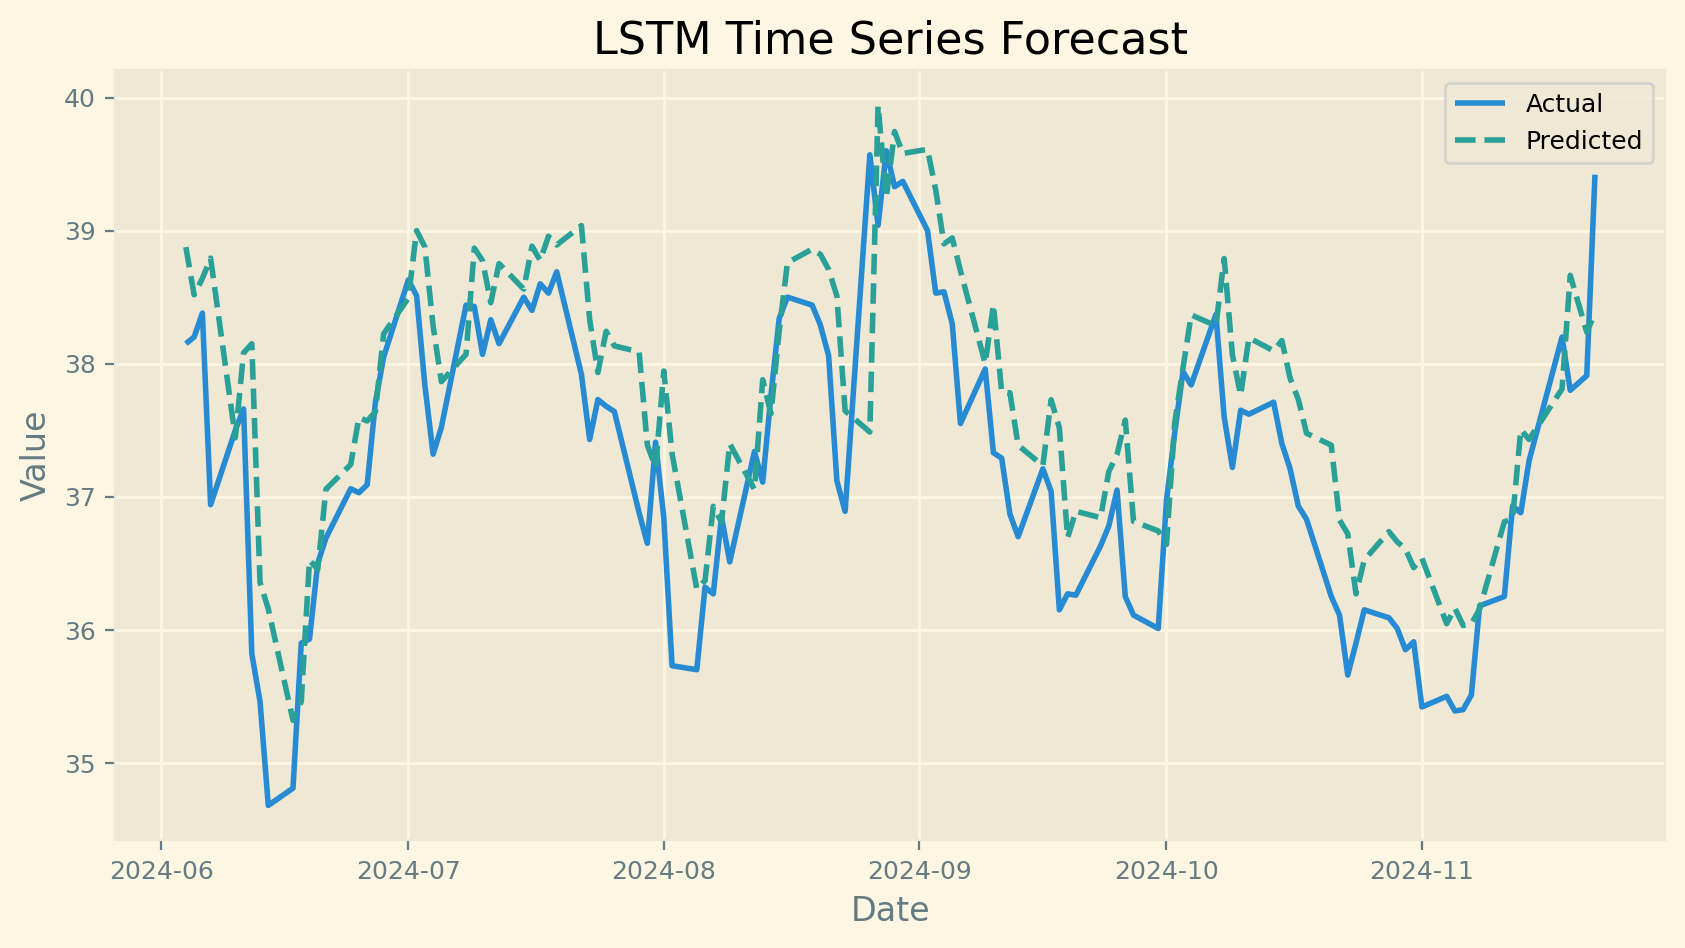

RMSE: 0.73


In [20]:
# Initialize an empty list to store predictions
predictions = []

# Set model to evaluation mode
model.eval()
with torch.no_grad():  # Disable gradient calculation for inference
    for seq in x_test:
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        )
        predictions.append(model(seq).item())  # Get the scalar prediction and append to list

# Convert predictions and test labels back to the original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plot the results
plt.figure(figsize=(10,5))
plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual')
plt.plot(stock_data.index[-len(predictions):], predictions, label='Predicted', linestyle='--')
plt.title('LSTM Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
print('RMSE: %.2f' % (root_mean_squared_error(y_test, predictions)))